In [3]:
# -*- coding: utf-8 -*-

import json
import pickle
import os
import sys
import nltk
from nltk import meteor_score
# from nltk.tokenize import word_tokenize 
# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
from nltk.translate import meteor_score
from collections import defaultdict

from itertools import product
import scipy
from scipy import stats
from scipy.spatial.distance import euclidean
import pulp

import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import re

import matplotlib.pyplot as plt
%matplotlib inline

# Data Exploration

In [4]:
#read all json data
data_path = sys.path[0]+"/human_assessment/"

with open(data_path+'MMTsourcedict.json') as json_file:
    src_dict = json.load(json_file)
with open(data_path+'MMTgolddict_de.json') as json_file:
    ref_de_dict = json.load(json_file)
with open(data_path+'MMTtranslationdict_de.json') as json_file:
    mt_de_dict = json.load(json_file)
with open(data_path+'MMTgolddict_fr.json') as json_file:
    ref_fr_dict = json.load(json_file)
with open(data_path+'MMTtranslationdict_fr.json') as json_file:
    mt_fr_dict = json.load(json_file)

In [5]:
def clean_up_french(ref_fr_dict, mt_fr_dict):
    tmp = ref_fr_dict.items()
    for key, value in tmp:
        new_val = re.sub(r"&\w+;\s","'",value)
        ref_fr_dict[key] = new_val

    tmp = mt_fr_dict.items()
    for key, value in tmp:
            new_val = [[re.sub(r"&\w+;\s","'",item[0]),item[1]]for item in value]
            mt_fr_dict[key] = new_val
    return ref_fr_dict, mt_fr_dict
    
ref_fr_dict, mt_fr_dict = clean_up_french(ref_fr_dict, mt_fr_dict)
    

# print(ref_fr_dict["30167206992.jpg"])
# print(mt_fr_dict["30167206992.jpg"])

print(ref_fr_dict["27124904596.jpg"])
print()
for i in mt_fr_dict["27124904596.jpg"]:
    print(i[0]+"\n")

une photo aérienne d'un paysage d'herbe brunissante avec une sorte de château culminant , et un paysage montagneux à l'horizon .

une photo aérienne de seniors et d'une belle structure ressemblant à travers un paysage de montagne dans l'horizon.

un paysage de signalisation, regarde de la prairie et une structure ressemblant à une structure à l'intérieur et un paysage de montagne à l'horizon.

une photo de paysage aérienne d'une prairie et d'une structure ressemblant à une structure en hauteur et un paysage de montagne à l'horizon.

une photo de pêcheurs aérienne de paille et d'une structure brumeuse regarde au loin et un paysage de montagne à l'horizon.



In [6]:
# matching image id for src sent, ref sent, translation sent

## Sorting if necessary
# sorted_src_dict = {key: value for key, value in sorted(src_dict.items(), key=lambda item: item[0])}
# ref_de_dict = {key: value for key, value in sorted(ref_de_dict.items(), key=lambda item: item[0])}
# score_de_dict = {key: value for key, value in sorted(score_de_dict.items(), key=lambda item: item[0])}

de_match = {}
assert len(src_dict) == len(ref_de_dict)
for src_id in src_dict:
    if src_id in mt_de_dict and src_id in ref_de_dict:
         de_match[src_id] = [src_dict[src_id], ref_de_dict[src_id], mt_de_dict[src_id]]
    else:
        de_match[src_id] = [src_dict[src_id], ref_de_dict[src_id], []] # Assign empty list for Non-score sentences
print(len(de_match))


fr_match = {}
assert len(src_dict) == len(ref_fr_dict)
for src_id in src_dict:
    if src_id in mt_fr_dict and src_id in ref_fr_dict:
         fr_match[src_id] = [src_dict[src_id], ref_fr_dict[src_id], mt_fr_dict[src_id]]
    else:
        fr_match[src_id] = [src_dict[src_id], ref_fr_dict[src_id], []]
print(len(fr_match))

1000
1000


In [7]:
#extract all sentence data from dictionaries

#1. source sentences in English
src_sent = [item[0] for item in de_match.values()]

#2. reference German sentences
ref_de_sent = [item[1] for item in de_match.values()]

#3. reference french sentences
ref_fr_sent = [item[1] for item in fr_match.values()]

#4. translation score on German sentences
mt_de = [item[2] for item in de_match.values()]
        
#5. translation score on French sentences
mt_fr = [item[2] for item in fr_match.values()]


In [8]:
# Assert fr, de source order are the same
assert list(fr_match.keys()) == list(de_match.keys())

In [9]:
#sentence preprocessing on source sentences
# {img_id: [preprocessed tokens ... ]}

def data_processing(src_sents, tokenizer, stop_words=None, MT=False):    
    token_sents = []
    
    for i in range(len(src_sents)): 
        if MT: 
            sent = src_sents[i][0]
        else:
            sent = src_sents[i]
            
#         sent = sent.lower() 
        word_list = tokenizer.tokenize(sent) # Tokenizer
#       word_list = [w for w in word_list if not w in stop_words] # stop words removal
#         word_list = [w for w in word_list if w.isalnum()] # punct_filtered

        #stemming
        # stemmer = SnowballStemmer('english')
        # sentence_stemmed = []
        # for token in punct_filtered:
        #     sentence_stemmed.append(stemmer.stem(token))
        
        if MT: 
            token_sents.append([word_list, src_sents[i][1]])
        else:    
            token_sents.append(word_list)
 
    return token_sents

In [10]:
# stop_words = stopwords.words('english')
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

img_ids = list(src_dict.keys())

src_tokens= {idx: val for idx, val in zip(img_ids, data_processing(src_sent, bert_tokenizer))}
ref_de_tokens = {idx: val for idx, val in zip(img_ids, data_processing(ref_de_sent, bert_tokenizer))}
ref_fr_tokens = {idx: val for idx, val in zip(img_ids, data_processing(ref_fr_sent, bert_tokenizer))}

mt_fr_tokens = {idx:data_processing(fr_sent, bert_tokenizer, MT=True) for idx, fr_sent in zip(img_ids,mt_fr)}
mt_de_tokens = {idx:data_processing(de_sent, bert_tokenizer, MT=True) for idx, de_sent in zip(img_ids, mt_de)}


In [11]:
# def oneByone_match(src_sent, ref_sent, mt_sent):
#     source = []
#     reference = []
#     machineTranslation = []
#     score = []

#     for i in range(len(ref_sent)):
#         src = src_sent[i]
#         ref = ref_sent[i]        
#         for mt in mt_sent[i]:
#             if mt:
#                 source.append(src)
#                 reference.append(ref)
#                 machineTranslation.append(mt[0])
#                 score.append(mt[1])
#     return (source, reference, machineTranslation, score)

In [12]:
# print(len(src_sent))
# print(len(ref_de_sent))
# print(len(mt_de))
# de_sent = oneByone_match(src_sent, ref_de_sent, mt_de)
# print(len(de_sent))
# fr_sent = oneByone_match(src_sent, ref_fr_sent, mt_fr)
# print(len(fr_sent))

In [13]:
### Test

i = 30
img_id = img_ids[i]
print(f"Image id: {img_id}\n")
print(f"Original source sentence:\n{src_sent[i]}\n")
print(f"Tokenized source sentence:\n{src_tokens[img_id]}\n")
print(f"Original reference German sentence:\n{ref_de_sent[i]}\n")
print(f"Tokenized reference German sentence:\n{ref_de_tokens[img_id]}\n")
print(f"Original reference French sentence:\n{ref_fr_sent[i]}\n")
print(f"Tokenized reference French sentence:\n{ref_fr_tokens[img_id]}\n")

print(mt_fr[i])
print(mt_fr_tokens[img_id])


for i in range(len(src_sent)):
    assert src_sent[i] == src_dict[img_ids[i]]
    assert ref_fr_sent[i] == ref_fr_dict[img_ids[i]]
    if len(mt_fr[i]) > 0:
        assert mt_fr[i] == mt_fr_dict[img_ids[i]]        

Image id: 25622467670.jpg

Original source sentence:
privately owned poster and restaurant poster

Tokenized source sentence:
['privately', 'owned', 'poster', 'and', 'restaurant', 'poster']

Original reference German sentence:
schild für privatbesitz und schild eines restaurants

Tokenized reference German sentence:
['s', '##child', 'für', 'privat', '##besitz', 'und', 's', '##child', 'eines', 'restaurants']

Original reference French sentence:
une pancarte 'propriété privée 'et un panneau pour un restaurant

Tokenized reference French sentence:
['une', 'pan', '##car', '##te', "'", 'propriété', 'privée', "'", 'et', 'un', 'pan', '##neau', 'pour', 'un', 'restaurant']

[['une affiche aveuse et un restaurant .', -1.60627323003466], ['une maison apprenant à une affiche de restaurant et une affiche de restaurant', -0.351114913586192], ['une affiche et des', -1.60795922940204]]
[[['une', 'affiche', 'ave', '##use', 'et', 'un', 'restaurant', '.'], -1.60627323003466], [['une', 'maison', 'app', '#

# WMD with Bert embedding

In [14]:
use_GPU = torch.cuda.is_available()
device = torch.device("cuda" if use_GPU else "cpu")
print('Device: ' + str(device))
if use_GPU:
    torch.cuda.manual_seed(0)
    print('GPU: ' + str(torch.cuda.get_device_name(int("0")))) 
print("Using GPU: {}".format(use_GPU))

Device: cpu
Using GPU: False


## Bert

In [15]:
def bert_tokenization(txt, tokenizer):
    
    tokens = tokenizer.tokenize("[CLS] " + txt + " [SEP]")
    
    indexed_tokens= torch.tensor(tokenizer.convert_tokens_to_ids(tokens)).unsqueeze(0)
    segments_ids = torch.tensor([0]*len(tokens)).unsqueeze(0)

    return tokens[1:-1], indexed_tokens, segments_ids 

In [16]:
### Each Layers' output
def layer_processing(model):
    layers = []

    def layer_hook(module, input_, output):
        layers.append(output[0])

    for i in model.encoder.layer:
        i.register_forward_hook(layer_hook)

    return layers

In [17]:
from transformers import BertTokenizer, BertModel
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased', return_dict=True)
# bert_model.embeddings.word_embeddings
bert_model.eval()
print()


In [18]:
# Test for Bert base multilingual cased
# ref_tokens, ref_id, ref_seg = bert_tokenization(ref_de_sent[0], bert_tokenizer)
# output = bert_model(ref_id)
# print(ref_de_sent[0])
# print(ref_tokens)
# # print(bert_model.embeddings.word_embeddings(torch.tensor(bert_tokenizer(ref_de_sent[0])["input_ids"])).size())
# print(f"Num of tokens: {len(ref_tokens)}")
# print(f"Last State size: {output.last_hidden_state[:,1:-1,:].size()}")
# print(f"Pooling state size: {output.pooler_output.size()}")

ref_tokens = bert_tokenizer.tokenize(ref_de_sent[0])
ref_id = bert_tokenizer(ref_de_sent[0],return_tensors="pt")
output = bert_model(ref_id['input_ids'])

print(ref_de_sent[0])
print(ref_tokens)
# print(bert_model.embeddings.word_embeddings(torch.tensor(bert_tokenizer(ref_de_sent[0])["input_ids"])).size())
print(f"Num of tokens: {len(ref_tokens)}")
print(f"Last State size: {output.last_hidden_state[:,1:-1,:].size()}")
print(f"Pooling state size: {output.pooler_output.size()}")
print(output.last_hidden_state)

### Each Layers' output
# def processing(model):
#     layers = []

#     def layer_hook(module, input_, output):
#         layers.append(output[0])

#     for i in model.encoder.layer:
#         i.register_forward_hook(layer_hook)

#     return layers

# import time
# start = time.time()
layers = layer_processing(bert_model)
bert_model(bert_tokenizer(ref_de_sent[0],return_tensors="pt")['input_ids'])
print(layers[0].size())
out = torch.stack(layers[-4:]).squeeze(1).permute(1,0,2)
result = torch.mean(out, dim=1)
print(result)

# layers2 = layer_processing(bert_model)
# bert_model(bert_tokenizer(ref_de_sent[1],return_tensors="pt")['input_ids'])
# out = torch.stack(layers[-4:]).squeeze(1).permute(1,0,2)
# result = torch.mean(out, dim=1)
# print(result)
# end = time.time()- start
# print(end)

ein schlanker gelblicher hund beim absolvieren eines hindernislaufs , der in einem bereich mit nacktem erdboden aufgebaut ist
['ein', 's', '##ch', '##lank', '##er', 'gel', '##bliche', '##r', 'hun', '##d', 'beim', 'ab', '##sol', '##vieren', 'eines', 'hin', '##dern', '##is', '##lauf', '##s', ',', 'der', 'in', 'einem', 'bere', '##ich', 'mit', 'na', '##ckte', '##m', 'er', '##d', '##boden', 'aufgebaut', 'ist']
Num of tokens: 35
Last State size: torch.Size([1, 35, 768])
Pooling state size: torch.Size([1, 768])
tensor([[[ 0.1663,  0.1419,  0.5582,  ...,  0.6827,  0.3857, -0.2903],
         [-0.0510, -0.1802,  1.6126,  ...,  1.4017,  0.7537, -0.3717],
         [ 0.3190, -0.2010,  0.5316,  ...,  0.8072,  0.5635, -0.2885],
         ...,
         [-0.0127, -0.5426,  0.6768,  ...,  0.7602,  0.9277, -0.4390],
         [ 0.1554, -0.3840,  0.4842,  ...,  1.5283,  1.1576, -0.3436],
         [-0.0743, -0.0172,  1.3659,  ...,  0.9191,  0.6367, -0.3853]]],
       grad_fn=<NativeLayerNormBackward>)
torch.

In [19]:
## (Discard bert-base-multilingual-uncased)

In [20]:
# from transformers import AutoTokenizer, AutoModel
# bert_tokenizer_un = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
# bert_model_un = AutoModel.from_pretrained("bert-base-multilingual-uncased",return_dict=True)
# # bert_model_un.embeddings.word_embeddings
# bert_model_un.eval()
# print()

In [21]:
# # Test for Bert base multilingual uncased
# ref_tokens, ref_id, ref_seg = bert_tokenization(ref_fr_sent[30], bert_tokenizer_un)
# output = bert_model_un(ref_id)

# print(ref_fr_sent[30])
# print(ref_tokens)
# print(f"Num of tokens: {len(ref_tokens)}")
# print(f"Last State size: {output.last_hidden_state[:,1:-1,:].size()}")
# print(f"Pooling state size: {output.pooler_output.size()}")

## XLM-RoBERTa

In [22]:
def xlm_roberta_tokenization(txt, tokenizer):
    
    tokens = tokenizer.tokenize("<s> " + txt + " </s>")
    
    indexed_tokens= torch.tensor(tokenizer.convert_tokens_to_ids(tokens)).unsqueeze(0)

    return tokens[1:-1], indexed_tokens 

In [23]:
from transformers import AutoTokenizer, AutoModel
xlm_r_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
xlm_r_model = AutoModel.from_pretrained("xlm-roberta-base",return_dict=True)
xlm_r_model.eval()
# xlm_r_model.embeddings.word_embeddings
print()

In [20]:
# Test for xlm-roberta-base

# ref_tokens = xlm_r_tokenizer.tokenize(ref_de_sent[0])
# ref_id = xlm_r_tokenizer(ref_de_sent[0], return_tensors="pt")
ref_tokens, ref_id = xlm_roberta_tokenization(ref_fr_sent[30], xlm_r_tokenizer)
output = xlm_r_model(ref_id)

print(ref_fr_sent[30])
print(ref_tokens)
print(f"Num of tokens: {len(ref_tokens)}")
print(f"Last State size: {output.last_hidden_state[:,1:-1,:].size()}")
print(f"Pooling state size: {output.pooler_output.size()}")


une pancarte 'propriété privée 'et un panneau pour un restaurant
['▁une', '▁pan', 'car', 'te', "▁'", 'prop', 'ri', 'été', '▁privée', "▁'", 'et', '▁un', '▁panne', 'au', '▁pour', '▁un', '▁restaurant']
Num of tokens: 17
Last State size: torch.Size([1, 17, 768])
Pooling state size: torch.Size([1, 768])


## DistilBert

In [21]:
from transformers import AutoTokenizer, AutoModel
distil_bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
distil_bert_model = AutoModel.from_pretrained("distilbert-base-multilingual-cased", return_dict=True)
distil_bert_model.eval()
# distil_bert_model.embeddings.word_embeddings
print()

In [26]:
# Test for distilBert
ref_tokens = distil_bert_tokenizer.tokenize(ref_fr_sent[30])
ref_id = distil_bert_tokenizer(ref_fr_sent[30], return_tensors="pt")
output = distil_bert_model(ref_id['input_ids'])

print(ref_fr_sent[30])
print(ref_tokens)
print(f"Num of tokens: {len(ref_tokens)}")
print(f"Last State size: {output.last_hidden_state[:,1:-1,:].size()}")

une pancarte 'propriété privée 'et un panneau pour un restaurant
['une', 'pan', '##car', '##te', "'", 'propriété', 'privée', "'", 'et', 'un', 'pan', '##neau', 'pour', 'un', 'restaurant']
Num of tokens: 15
Last State size: torch.Size([1, 15, 768])


In [27]:
# from transformers import RobertaTokenizer, RobertaModel
# roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# roberta_model = RobertaModel.from_pretrained("roberta-base")
# roberta_model.eval()
# print()

# from transformers import AutoTokenizer, AutoModel
# xlm_mlm_tokenizer = AutoTokenizer.from_pretrained("xlm-mlm-100-1280")
# xlm_mlm_model = AutoModel.from_pretrained("xlm-mlm-100-1280")
# xlm_mlm_model.eval()
# print()

In [28]:
# ref_tokens = roberta_tokenizer.tokenize(ref_de_sent[0])
# ref_id = roberta_tokenizer(ref_de_sent[0], return_tensors="pt")

# output = distil_bert_model(ref_id['input_ids'])
# print(ref_de_sent[0])
# print(len(ref_tokens))
# print(output.last_hidden_state.size())


## Meteor Score & Fluent based penalty

In [24]:
# -*- coding: utf-8 -*-
# Natural Language Toolkit: Machine Translation
#
# Copyright (C) 2001-2020 NLTK Project
# Author: Uday Krishna <udaykrishna5@gmail.com>
# URL: <http://nltk.org/>
# For license information, see LICENSE.TXT


from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from itertools import chain, product

def _generate_enums(hypothesis, reference, preprocess=str.lower):
    """
    Takes in string inputs for hypothesis and reference and returns
    enumerated word lists for each of them

    :param hypothesis: hypothesis string
    :type hypothesis: str
    :param reference: reference string
    :type reference: str
    :preprocess: preprocessing method (default str.lower)
    :type preprocess: method
    :return: enumerated words list
    :rtype: list of 2D tuples, list of 2D tuples
    """
    hypothesis_list = list(enumerate(preprocess(hypothesis).split()))
    reference_list = list(enumerate(preprocess(reference).split()))
    return hypothesis_list, reference_list


def exact_match(hypothesis, reference):
    """
    matches exact words in hypothesis and reference
    and returns a word mapping based on the enumerated
    word id between hypothesis and reference

    :param hypothesis: hypothesis string
    :type hypothesis: str
    :param reference: reference string
    :type reference: str
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    hypothesis_list, reference_list = _generate_enums(hypothesis, reference)
    return _match_enums(hypothesis_list, reference_list)



def _match_enums(enum_hypothesis_list, enum_reference_list):
    """
    matches exact words in hypothesis and reference and returns
    a word mapping between enum_hypothesis_list and enum_reference_list
    based on the enumerated word id.

    :param enum_hypothesis_list: enumerated hypothesis list
    :type enum_hypothesis_list: list of tuples
    :param enum_reference_list: enumerated reference list
    :type enum_reference_list: list of 2D tuples
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        for j in range(len(enum_reference_list))[::-1]:
            if enum_hypothesis_list[i][1] == enum_reference_list[j][1]:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                (enum_hypothesis_list.pop(i)[1], enum_reference_list.pop(j)[1])
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def _enum_stem_match(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer()
):
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between enum_hypothesis_list and
    enum_reference_list based on the enumerated word id. The function also
    returns a enumerated list of unmatched words for hypothesis and reference.

    :param enum_hypothesis_list:
    :type enum_hypothesis_list:
    :param enum_reference_list:
    :type enum_reference_list:
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    stemmed_enum_list1 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_hypothesis_list
    ]

    stemmed_enum_list2 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_reference_list
    ]

    word_match, enum_unmat_hypo_list, enum_unmat_ref_list = _match_enums(
        stemmed_enum_list1, stemmed_enum_list2
    )

    enum_unmat_hypo_list = (
        list(zip(*enum_unmat_hypo_list)) if len(enum_unmat_hypo_list) > 0 else []
    )

    enum_unmat_ref_list = (
        list(zip(*enum_unmat_ref_list)) if len(enum_unmat_ref_list) > 0 else []
    )

    enum_hypothesis_list = list(
        filter(lambda x: x[0] not in enum_unmat_hypo_list, enum_hypothesis_list)
    )

    enum_reference_list = list(
        filter(lambda x: x[0] not in enum_unmat_ref_list, enum_reference_list)
    )

    return word_match, enum_hypothesis_list, enum_reference_list


def stem_match(hypothesis, reference, stemmer=PorterStemmer()):
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between hypothesis and reference

    :param hypothesis:
    :type hypothesis:
    :param reference:
    :type reference:
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that
                   implements a stem method
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_stem_match(enum_hypothesis_list, enum_reference_list, stemmer=stemmer)



def _enum_wordnetsyn_match(enum_hypothesis_list, enum_reference_list, wordnet=wordnet):
    """
    Matches each word in reference to a word in hypothesis
    if any synonym of a hypothesis word is the exact match
    to the reference word.

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: list of matched tuples, unmatched hypothesis list, unmatched reference list
    :rtype:  list of tuples, list of tuples, list of tuples

    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        hypothesis_syns = set(
            chain(
                *[
                    [
                        lemma.name()
                        for lemma in synset.lemmas()
                        if lemma.name().find("_") < 0
                    ]
                    for synset in wordnet.synsets(enum_hypothesis_list[i][1])
                ]
            )
        ).union({enum_hypothesis_list[i][1]})
        for j in range(len(enum_reference_list))[::-1]:
            if enum_reference_list[j][1] in hypothesis_syns:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                enum_hypothesis_list.pop(i), enum_reference_list.pop(j)
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def wordnetsyn_match(hypothesis, reference, wordnet=wordnet):
    """
    Matches each word in reference to a word in hypothesis if any synonym
    of a hypothesis word is the exact match to the reference word.

    :param hypothesis: hypothesis string
    :param reference: reference string
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: list of mapped tuples
    :rtype: list of tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )



def _enum_allign_words(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer(), wordnet=wordnet
):
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    in case there are multiple matches the match which has the least number
    of crossing is chosen. Takes enumerated list as input instead of
    string input

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: sorted list of matched tuples, unmatched hypothesis list,
             unmatched reference list
    :rtype: list of tuples, list of tuples, list of tuples
    """
    exact_matches, enum_hypothesis_list, enum_reference_list = _match_enums(
        enum_hypothesis_list, enum_reference_list
    )

    stem_matches, enum_hypothesis_list, enum_reference_list = _enum_stem_match(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer
    )

    wns_matches, enum_hypothesis_list, enum_reference_list = _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )

    return (
        sorted(
            exact_matches + stem_matches + wns_matches, key=lambda wordpair: wordpair[0]
        ),
        enum_hypothesis_list,
        enum_reference_list,
    )


def allign_words(hypothesis, reference, stemmer=PorterStemmer(), wordnet=wordnet):
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    In case there are multiple matches the match which has the least number
    of crossing is chosen.

    :param hypothesis: hypothesis string
    :param reference: reference string
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: sorted list of matched tuples, unmatched hypothesis list, unmatched reference list
    :rtype: list of tuples, list of tuples, list of tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_allign_words(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer, wordnet=wordnet
    )

def _count_chunks(matches):
    """
    Counts the fewest possible number of chunks such that matched unigrams
    of each chunk are adjacent to each other. This is used to caluclate the
    fragmentation part of the metric.

    :param matches: list containing a mapping of matched words (output of allign_words)
    :return: Number of chunks a sentence is divided into post allignment
    :rtype: int
    """
    i = 0
    chunks = 1
    while i < len(matches) - 1:
        if (matches[i + 1][0] == matches[i][0] + 1) and (
            matches[i + 1][1] == matches[i][1] + 1
        ):
            i += 1
            continue
        i += 1
        chunks += 1
    return chunks

def penalty(    
    reference,
    hypothesis,
    preprocess=str.lower,
    stemmer=PorterStemmer(),
    wordnet=wordnet):
    
    enum_hypothesis, enum_reference = _generate_enums(
        hypothesis, reference, preprocess=preprocess
    )
    
    translation_length = len(enum_hypothesis)
    reference_length = len(enum_reference)
    
    matches, _, _ = _enum_allign_words(enum_hypothesis, enum_reference, stemmer=stemmer)
    
    matches_count = len(matches)
    
    try:
        chunk_count = float(_count_chunks(matches))
        frag_frac = chunk_count / matches_count
        
    except ZeroDivisionError: # No unigrams match
        return 0
    
    return frag_frac


In [25]:
## From the aspects of model embedding.
def tokens_to_fracdict(tokens):
    cntdict = defaultdict(lambda : 0)
        
    for token in tokens:
        cntdict[token] += 1
    totalcnt = sum(cntdict.values())
    return {token: float(cnt)/totalcnt for token, cnt in cntdict.items()}

## From the aspects of model output, considering contextual relationship.
## Each tokens means different, even they are the same.
def tokens_to_fracdict_contextual(tokens):
    
    return {token: 1/len(tokens) for token in range(len(tokens))}

In [36]:
## There are two components can be used as embedding
## 1) model embedding 
## 2) Model output states

def embedding_processing(sent1, sent2, tokenizer, model, embed_type):
    
    sent1_tokens = tokenizer.tokenize(sent1)
    sent2_tokens = tokenizer.tokenize(sent2)
    
    if embed_type == 1:
        
        sent1_buckets = tokens_to_fracdict(sent1_tokens)
        sent2_buckets = tokens_to_fracdict(sent2_tokens) 
        
        sent1_embedding = model.embeddings.word_embeddings(torch.tensor(tokenizer.convert_tokens_to_ids(list(sent1_buckets.keys()))))
        sent2_embedding = model.embeddings.word_embeddings(torch.tensor(tokenizer.convert_tokens_to_ids(list(sent2_buckets.keys()))))
        
    elif embed_type == 2:
        
#         sent1_buckets = tokens_to_fracdict(sent1_tokens)
#         sent2_buckets = tokens_to_fracdict(sent2_tokens) 
        
        sent1_buckets = tokens_to_fracdict_contextual(sent1_tokens)
        sent2_buckets = tokens_to_fracdict_contextual(sent2_tokens) 
        
        sent1_id = tokenizer(sent1,return_tensors="pt")
        sent2_id = tokenizer(sent2,return_tensors="pt")
        
#         sent1_embedding = model(sent1_id['input_ids']).last_hidden_state.squeeze(0)
#         sent2_embedding = model(sent2_id['input_ids']).last_hidden_state.squeeze(0)


        layers = layer_processing(model)

        model(sent1_id['input_ids'])
        sent1_embedding = torch.mean(torch.stack(layers[-4:]).squeeze(1).permute(1,0,2), dim=1)
        
        model(sent2_id['input_ids'])
        sent2_embedding = torch.mean(torch.stack(layers[-4:]).squeeze(1).permute(1,0,2), dim=1)
        
        del layers
    
    
    if sent1_embedding.size()[0] - 2 == len(sent1_tokens):
        sent1_embedding = sent1_embedding[1:-1,:] # Remove bos and eos tokens

    if sent2_embedding.size()[0] - 2 == len(sent2_tokens):
        sent2_embedding = sent2_embedding[1:-1,:] # Remove bos and eos tokens  
    
    
    all_embedding = torch.cat([sent1_embedding, sent2_embedding])
    
#     print(len(sent1_tokens))
#     print(len(sent2_tokens))
#     print(sent1_embedding.size())
#     print(sent2_embedding.size())

    assert len(sent1_buckets) + len(sent2_buckets) == all_embedding.size()[0]
    
    return sent1_buckets, sent2_buckets, all_embedding

In [27]:
def word_mover_distance_probspec(sent1_buckets, sent2_buckets, all_embedding, lpFile=None,):
    
#     first_sent_tokens  = bert_tokenizer.tokenize(first_sent)
#     second_sent_tokens = bert_tokenizer.tokenize(second_sent)
    
#     first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
#     second_sent_buckets = tokens_to_fracdict(second_sent_tokens)
    
#     first_sent_embedding = model.embeddings.word_embeddings(torch.tensor(bert_tokenizer.convert_tokens_to_ids(list(first_sent_buckets.keys()))))
#     second_sent_embedding = model.embeddings.word_embeddings(torch.tensor(bert_tokenizer.convert_tokens_to_ids(list(second_sent_buckets.keys()))))
    
#     all_embedding = torch.cat([first_sent_embedding, second_sent_embedding])
    
    
#     first_sent_tokens, first_id, first_seg  = bert_tokenization(first_sent, bert_tokenizer)
#     second_sent_tokens, second_id, second_seg = bert_tokenization(second_sent, bert_tokenizer)
    
#     first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
#     second_sent_buckets = tokens_to_fracdict(second_sent_tokens)
    
#     first_sent_embedding = bert_processing(first_id, first_seg, model)
#     second_sent_embedding = bert_processing(second_id, second_seg, model)
    
#     all_embedding = torch.cat([first_sent_embedding, second_sent_embedding])
    
    
    # Updated buckets with labeled name
    first_sent_buckets = {f"x{idx}": item[1] for idx, item in enumerate(sent1_buckets.items())}
    second_sent_buckets = {f"y{idx}": item[1] for idx, item in enumerate(sent2_buckets.items())}

    var_names = list(first_sent_buckets.keys()) + list(second_sent_buckets.keys())
    
    assert len(var_names) == all_embedding.size(0)
    
    wordvecs = {token: embedding.detach().numpy() for token, embedding in zip(var_names, all_embedding)}
    
    
    T = pulp.LpVariable.dicts('T_matrix', list(product(var_names, var_names)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(var_names, var_names)])
    
    for token2 in second_sent_buckets:   #constrains
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
        
    for token1 in first_sent_buckets:    #constrains
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [28]:
def word_mover_distance(sent1, sent2, tokenizer, model, embed_type, lpFile=None):
    
    sent1_buckets, sent2_buckets, embeddings = embedding_processing(sent1, sent2, tokenizer, model, embed_type)
    
    prob = word_mover_distance_probspec(sent1_buckets, sent2_buckets, embeddings, lpFile=lpFile)
    
    return pulp.value(prob.objective)

In [29]:
def fluency_based_wmd(wmd, ref, hypo, gamma=0.2):
    
    frag_penalty = penalty(ref, hypo)

    # print(frag_penalty)
    
    return wmd - gamma *(0.5 - frag_penalty)

In [30]:
# embedding_processing(src_sent[0],ref_de_sent[0], bert_tokenizer, bert_model,1)

# Evaluation

In [31]:
def compute_WMD_WMDo(ref_sent, mt_sent, tokenizer, model, embed_type):
    score = []
    wmd = []
    wmdo =[]

    for i in range(len(ref_sent)):
        ref = ref_sent[i]        
        for mt in mt_sent[i]:
            if mt:
                hypo = mt[0]
                wmd_tmp = word_mover_distance(ref, hypo, tokenizer, model, embed_type)
                wmdo_tmp = fluency_based_wmd(wmd_tmp, ref, hypo)
#                 wmdo_tmp = 0
                score.append(mt[1])
                wmd.append(wmd_tmp)
                wmdo.append(wmdo_tmp)

    return wmd, wmdo, score

In [32]:
# def compute_WMD_WMDo_alt(sent, tokenizer, model, embed_type):
#     wmd = []
#     wmdo =[]
    
#     buckets1 = []
#     buckets2 = []
#     all_embeddings = []
    
#     for i in range(len(sent[0])):
#         output = embedding_processing(sent[0][i], sent[2][i], tokenizer, model, embed_type) # src - mt
# #         embedding_processing(sent[1][i], sent[2][i], tokenizer, model, embed_type) # ref-mt
#         buckets1.append(output[0])
#         buckets2.append(output[1])
#         all_embeddings.append(output[2])
        
#     for k in range(len(buckets1)):
#         prob = word_mover_distance_probspec(buckets1[k], buckets2[k], all_embeddings[k], lpFile=lpFile)
#         wmd_tmp = pulp.value(prob.objective)
#         wmdo_tmp = fluency_based_wmd(wmd_tmp, sent[0][k], sent[2][k])
#         wmd.append(wmd_tmp)
#         wmdo.append(wmdo_tmp)

#     return wmd, wmdo, sent[3]

In [33]:
def evaluation(wmd, wmdo, score):
    pearson = stats.pearsonr(wmd, score)
    pearson_o = stats.pearsonr(wmdo, score)
    spearman = stats.spearmanr(wmd, score)
    spearman_o = stats.spearmanr(wmdo, score)
    print("Spearman Correlation:", spearman, spearman_o)
    print("Pearson Correlation:", pearson, pearson_o)
    return pearson, pearson_o, spearman, spearman_o

In [23]:
# de-de

In [54]:
wmd, wmdo, score = compute_WMD_WMDo(ref_de_sent, mt_de, bert_tokenizer, bert_model, embed_type=2)

In [128]:
print("German")
print(f"Average WMD: {sum(wmd)/len(wmd)}")
print(f"Average WMDo: {sum(wmdo)/len(wmdo)}")
_,_,_,_ = evaluation(wmd,wmdo,score)

German
Average WMD: 11.92350722838354
Average WMDo: 11.93565266229737
Spearman Correlation: SpearmanrResult(correlation=-0.5264900763599432, pvalue=9.299201394871157e-248) SpearmanrResult(correlation=-0.527825014510426, pvalue=3.116225736984183e-249)
Pearson Correlation: (-0.4988590021119278, 1.154527862257958e-218) (-0.5018554701795757, 1.0847530984382924e-221)


In [ ]:
German
Average WMD: 0.8017151844060595
Average WMDo: 0.8138606183198966
Spearman Correlation: SpearmanrResult(correlation=-0.510027596930398, pvalue=4.212314562585338e-230) SpearmanrResult(correlation=-0.5219619561321359, pvalue=8.359442710590678e-243)
Pearson Correlation: (-0.5097357138311421, 8.489667305524292e-230) (-0.5263318452409809, 1.3893750874154716e-247)
    
German
Average WMD: 0.8451170232446427
Average WMDo: 0.8572624571584787
Spearman Correlation: SpearmanrResult(correlation=-0.5167822958372177, pvalue=3.143442128396969e-237) SpearmanrResult(correlation=-0.527902437812766, pvalue=2.557939363753482e-249)
Pearson Correlation: (-0.5175614221899548, 4.623107333941656e-238) (-0.5331211335090894, 3.7759802184007295e-255)

German
Average WMD: 11.92350722838354
Average WMDo: 11.93565266229737
Spearman Correlation: SpearmanrResult(correlation=-0.5264900763599432, pvalue=9.299201394871157e-248) SpearmanrResult(correlation=-0.527825014510426, pvalue=3.116225736984183e-249)
Pearson Correlation: (-0.4988590021119278, 1.154527862257958e-218) (-0.5018554701795757, 1.0847530984382924e-221)


In [ ]:
# fr-fr

In [45]:
wmd, wmdo, score = compute_WMD_WMDo(ref_fr_sent, mt_fr, bert_tokenizer, bert_model, embed_type=1)

In [46]:
print("French")
print(f"Average WMD: {sum(wmd)/len(wmd)}")
print(f"Average WMDo: {sum(wmdo)/len(wmdo)}")
_,_,_,_ = evaluation(wmd, wmdo, score)

French
Average WMD: 0.6042960387747216
Average WMDo: 0.5843562557639091
Spearman Correlation: SpearmanrResult(correlation=-0.5088781037811415, pvalue=4.238102393698617e-166) SpearmanrResult(correlation=-0.5095276962031406, pvalue=1.3749251885221357e-166)
Pearson Correlation: (-0.4513739384178891, 9.4483659745375e-127) (-0.4753943913882638, 2.8100771767595054e-142)


In [26]:
# wmd, wmdo, score = compute_WMD_WMDo_alt(de_sent, bert_tokenizer, bert_model, embed_type=2)

In [27]:
# en-de

In [39]:
wmd, wmdo, score = compute_WMD_WMDo(src_sent, mt_de, bert_tokenizer, bert_model, embed_type=2)

In [ ]:
print("German")
print(f"Average WMD: {sum(wmd)/len(wmd)}")
print(f"Average WMDo: {sum(wmdo)/len(wmdo)}")
_,_,_,_ = evaluation(wmd, wmdo, score)

In [ ]:
German
Average WMD: 16.29980031455852
Average WMDo: 16.320027543797018
Spearman Correlation: SpearmanrResult(correlation=-0.29975434613344154, pvalue=2.927154570831462e-73) SpearmanrResult(correlation=-0.3013927051589536, pvalue=4.4202517417034795e-74)
Pearson Correlation: (-0.3005912689344727, 1.116147711745209e-73) (-0.30129563647873175, 4.9458153364140074e-74)

German
Average WMD: 3.3968153183780254
Average WMDo: 3.417042547616439
Spearman Correlation: SpearmanrResult(correlation=-0.21422866982477823, pvalue=1.885174503990756e-37) SpearmanrResult(correlation=-0.2145094834367832, pvalue=1.5113773772990689e-37)
Pearson Correlation: (-0.2268368401403627, 6.77521079069275e-42) (-

In [ ]:
# en-fr

In [131]:
wmd, wmdo, score = compute_WMD_WMDo(src_sent, mt_fr, bert_tokenizer, bert_model, embed_type=2)

In [132]:
print("French")
print(f"Average WMD: {sum(wmd)/len(wmd)}")
print(f"Average WMDo: {sum(wmdo)/len(wmdo)}")
_,_,_,_ = evaluation(wmd, wmdo, score)

French
Average WMD: 15.939521637425933
Average WMDo: 15.959814406385354
Spearman Correlation: SpearmanrResult(correlation=-0.3107695748544288, pvalue=1.4922483868658528e-57) SpearmanrResult(correlation=-0.3100484209631477, pvalue=2.7908644823368746e-57)
Pearson Correlation: (-0.2876862062916148, 3.1962490553298156e-49) (-0.2874546336258672, 3.840393624056795e-49)


In [ ]:
German
Average WMD: 10.427111590705742
Average WMDo: 0.0
Spearman Correlation: SpearmanrResult(correlation=-0.29534751301923506, pvalue=4.450031532655668e-71) SpearmanrResult(correlation=nan, pvalue=nan)
Pearson Correlation: (-0.27974182361659783, 1.1742674301265787e-63) (nan, nan)
    
German
Average WMD: 17.18350542242003
Average WMDo: 0.0
Spearman Correlation: SpearmanrResult(correlation=-0.32986204801567076, pvalue=3.242058011986647e-89) SpearmanrResult(correlation=nan, pvalue=nan)
Pearson Correlation: (-0.3227679331128431, 2.7421986260577897e-85) (nan, nan)

German
Average WMD: 17.18350542242003
Average WMDo: 0.0
Spearman Correlation: SpearmanrResult(correlation=-0.32986204801567076, pvalue=3.242058011986647e-89) SpearmanrResult(correlation=nan, pvalue=nan)
Pearson Correlation: (-0.3227679331128431, 2.7421986260577897e-85) (nan, nan)
    
French
Average WMD: 16.294238467579046
Average WMDo: 0.0
Spearman Correlation: SpearmanrResult(correlation=-0.3395921197358332, pvalue=4.690308677924282e-69) SpearmanrResult(correlation=nan, pvalue=nan)
Pearson Correlation: (-0.30687943931248707, 4.2809690344793455e-56) (nan, nan)
    
German
Average WMD: 18.81079347015398
Average WMDo: 0.0
Spearman Correlation: SpearmanrResult(correlation=-0.3707884378951234, pvalue=5.390859566935439e-114) SpearmanrResult(correlation=nan, pvalue=nan)
Pearson Correlation: (-0.3479911991188516, 9.749048459798403e-100) (nan, nan)


# Plot

In [96]:
norm_score = np.array(score)/np.sqrt(np.sum(np.array(score)**2))
norm_wmd = np.array(wmd)/ np.sqrt(np.sum(np.array(wmd)**2))
norm_wmdo = np.array(wmdo)/np.sqrt(np.sum(np.array(wmdo)**2))

# wmd = np.array(wmd) - (sum(wmd)/len(wmd))

/Users/yurunsong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


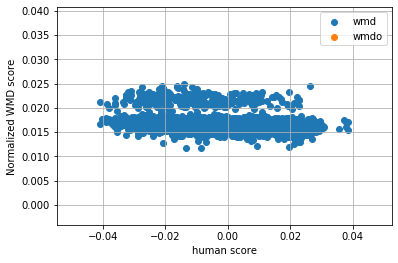

In [97]:
# plt.scatter(np.array(score)[:200],wmd[:200])
plt.scatter(norm_score,norm_wmd)
plt.scatter(norm_score,norm_wmdo)
# plt.xlim([-3,3])
# plt.ylim([-1.5,1.5])
plt.xlabel("human score")
plt.ylabel("Normalized WMD score")
plt.legend(["wmd", "wmdo"])
plt.grid()

In [29]:
# Appendix 

In [30]:
# def bert_processing(indexed_tokens,segments_ids, model):

# #     sentences_embedding = []

#     with torch.no_grad():

# #         for i in range(len(indexed_tokens)):

#         # "encoded_layers" has shape [12 x 1 x N x 768]

#         encoded_layers, _ = model(indexed_tokens, segments_ids)

#         token_embeddings = torch.stack(encoded_layers, dim=0)

#         token_embeddings = torch.squeeze(token_embeddings, dim=1)

#         token_embeddings = token_embeddings.permute(1,0,2)

#         # "token_embeddings" has shape [N x 12 x 768]

#         token_vecs_sum = []

#         for token in token_embeddings:
            
# #             sum_vec = torch.tensor(gen_mean(token, 4))
#             sum_vec = torch.mean(token[-4:], dim=0)

#             token_vecs_sum.append(sum_vec)

#         # "token_vecs" is a tensor with shape [N x 768]
        
#         token_vecs = torch.stack(token_vecs_sum, dim=0)

#     return token_vecs[1:-1,:]

In [31]:
# def gen_mean(vals, p):
#     p = float(p)
#     return np.power(np.mean(np.power(np.array(vals, dtype=np.float32),p),axis=0),1 / p)  


# def get_sentence_embedding(sentence, embeddings, chosen_operations):
#     word_embeddings = []
#     for tok in sentence:
#         vec = embeddings.vectors.get(tok)
#         if vec is not None:
#             word_embeddings.append(vec)

#     if not word_embeddings:
#         print('No word embeddings for sentence:\n{}'.format(sentence))
#         size = 0
#         for o in chosen_operations:
#             size += operations[o][1](embeddings.embeddings_dimensionality)
#         sentence_embedding = np.zeros(size)
#     else:
#         concat_embs = []
#         for o in chosen_operations:
#             concat_embs += operations[o][0](word_embeddings)
#         sentence_embedding = np.concatenate(
#             concat_embs,
#             axis=0
#         )

#     return sentence_embedding

In [38]:
# s1 = 'It is a guide to action which ensures that the military always obeys the commands of the party'
# s2 = 'It is a guide to action that ensures that the military will forever heed Party commands'

# sent1_buckets, sent2_buckets, embeddings = embedding_processing(s1, s2, bert_tokenizer, bert_model, 2)

# print(len(sent1_buckets))
# print(len(sent2_buckets))
# print(embeddings.size())
# print(embeddings)